In [ ]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
from collections import Counter
from torch.utils.data import random_split, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [63]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
from collections import Counter

Define Transformations

In [64]:
# Define transformations (Resizing and Normalizing)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize between -1 and 1
])

In [65]:
# Load dataset
data_dir = "rice_leaf_diseases"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

Split Data

In [66]:
# Split into Train (70%), Validation (15%), and Test (15%)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [67]:
# Get class names from folder structure
class_names = sorted(os.listdir(data_dir))  # List of class names

In [68]:
# Count images per class
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in class_names}

# Print class details
print("Class Names:", class_names)
print("Class Distribution:", class_counts)

Class Names: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']
Class Distribution: {'Bacterial leaf blight': 40, 'Brown spot': 40, 'Leaf smut': 40}


In [69]:
# Get class names and count images per class
class_counts = Counter([dataset.classes[label] for _, label in dataset.imgs])
print("Class Distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

Class Distribution:
Bacterial leaf blight: 40 images
Brown spot: 40 images
Leaf smut: 40 images


In [70]:
# Show sample images
def show_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        img, label = dataset[i]
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].set_title(f"Class: {dataset.classes[label]}")
        axes[i].axis("off")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..0.827451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.92156863].


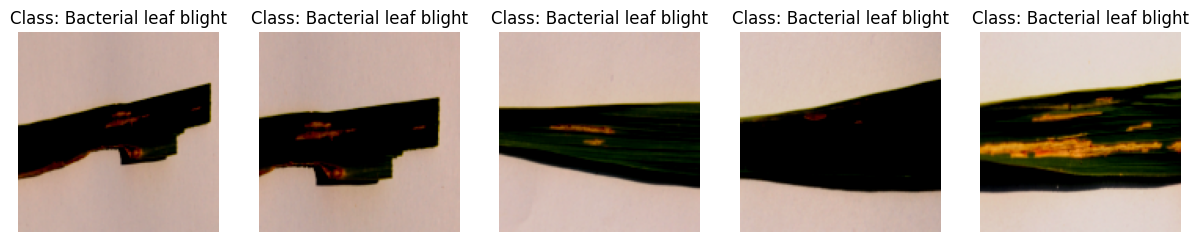

In [71]:
# Display sample images
show_samples(dataset)

In [72]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [73]:
# Check dataset sizes
print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

Train: 84, Val: 18, Test: 18


Define Model

In [74]:
class RiceDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(RiceDiseaseCNN, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        # Pooling & Dropout
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.4)

        # Compute flattened size dynamically
        self.flatten_size = self._compute_flatten_size()

        # Fully Connected Layers
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _compute_flatten_size(self):
        """Run a dummy forward pass to determine the correct flatten size."""
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 128, 128)  # Adjust based on actual input size
            x = self.conv_layers(dummy_input)
            return x.view(1, -1).size(1)

    def conv_layers(self, x):
        """Pass input through convolutional layers with pooling."""
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Define model
num_classes = len(dataset.classes)
model = RiceDiseaseCNN(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


RiceDiseaseCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)

Train Model

In [ ]:
train_losses = []
val_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate validation accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")


Epoch [1/10], Loss: 0.5383, Val Accuracy: 72.22%
Epoch [2/10], Loss: 0.4460, Val Accuracy: 72.22%
Epoch [3/10], Loss: 0.3237, Val Accuracy: 72.22%
Epoch [4/10], Loss: 0.2374, Val Accuracy: 77.78%
Epoch [5/10], Loss: 0.4701, Val Accuracy: 72.22%
Epoch [6/10], Loss: 0.3103, Val Accuracy: 72.22%
Epoch [7/10], Loss: 0.2437, Val Accuracy: 72.22%
Epoch [8/10], Loss: 0.3485, Val Accuracy: 72.22%
Epoch [9/10], Loss: 0.1433, Val Accuracy: 72.22%
Epoch [10/10], Loss: 0.1440, Val Accuracy: 72.22%


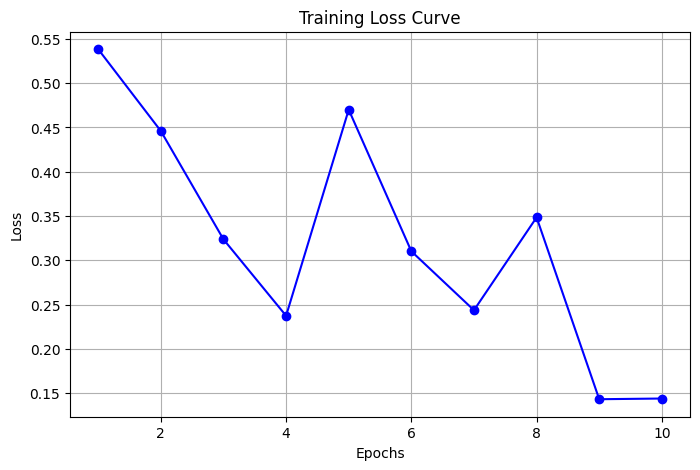

In [78]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid()
plt.show()


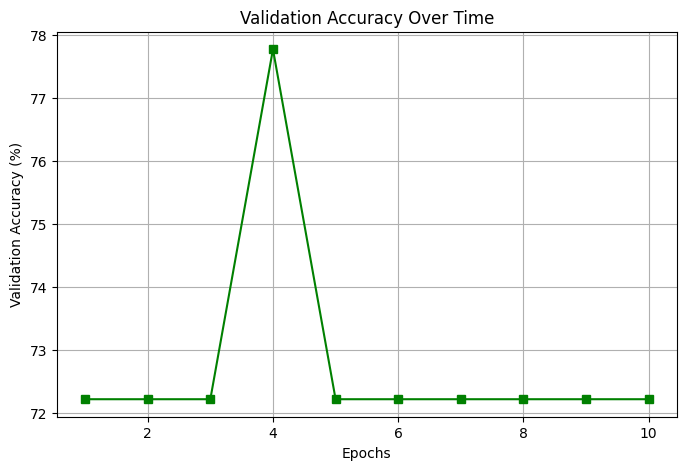

In [79]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), val_accuracies, marker='s', linestyle='-', color='green')
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Over Time")
plt.grid()
plt.show()


<Figure size 600x600 with 0 Axes>

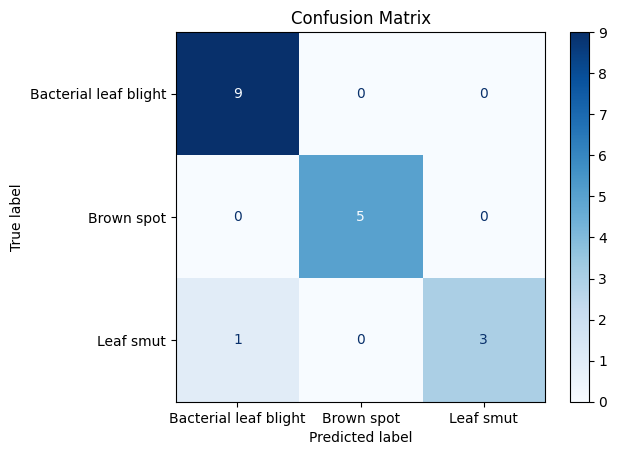

In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get model predictions on test data
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)

# Plot
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [81]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=dataset.classes))


                       precision    recall  f1-score   support

Bacterial leaf blight       0.90      1.00      0.95         9
           Brown spot       1.00      1.00      1.00         5
            Leaf smut       1.00      0.75      0.86         4

             accuracy                           0.94        18
            macro avg       0.97      0.92      0.93        18
         weighted avg       0.95      0.94      0.94        18



In [82]:
model_path = "rice_disease_cnn.pth"  # Save model as a .pth file
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to rice_disease_cnn.pth
